In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


In [ ]:
data = pd.read_csv('stocks_data.csv', index_col = 0)
data.head(2)



,Date,BA,DE,MSI,SPGI
0,1974-01-02,0.130799,1.094406,2.354811,0.191056
1,1974-01-03,0.132121,1.148318,2.440219,0.200771


In [ ]:
# Assuming the data has a 'Date' column and 'Close' price column
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [ ]:
# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['BA'].values.reshape(-1, 1))

In [ ]:
# Create sequences
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length])
    return np.array(sequences), np.array(labels)


In [ ]:
sequence_length = 60  # 60 days look back
X, y = create_sequences(scaled_data, sequence_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def build_model(units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [12]:
from keras_tuner import RandomSearch

def model_builder(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=50, max_value=200, step=50)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp_dropout))
    model.add(LSTM(units=hp_units))
    model.add(Dropout(hp_dropout))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')
    return model

tuner = RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='stock_price_tuning',
    project_name='stock_price_prediction'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM layer is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

Trial 5 Complete [00h 04m 41s]
val_loss: 0.00011773256361872579

Best val_loss So Far: 8.57474757746483e-05
Total elapsed time: 00h 37m 22s

The hyperparameter search is complete. The optimal number of units in the LSTM layer is 100.
The optimal dropout rate is 0.2.
The optimal learning rate is 0.001.



In [13]:
from keras_tuner import BayesianOptimization

def model_builder(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=50, max_value=200, step=50)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp_dropout))
    model.add(LSTM(units=hp_units))
    model.add(Dropout(hp_dropout))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')
    return model

tuner = BayesianOptimization(
    model_builder,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='/content/drive/MyDrive/Colab/LSTM/stock_price_tuning_bayesian',
    project_name='stock_price_prediction'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM layer is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

Trial 10 Complete [00h 14m 48s]
val_loss: 7.113046982946496e-05

Best val_loss So Far: 7.113046982946496e-05
Total elapsed time: 01h 33m 16s

The hyperparameter search is complete. The optimal number of units in the LSTM layer is 150.
The optimal dropout rate is 0.1.
The optimal learning rate is 0.001.



In [14]:
from keras_tuner import Hyperband

def model_builder(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=50, max_value=200, step=50)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp_dropout))
    model.add(LSTM(units=hp_units))
    model.add(Dropout(hp_dropout))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')
    return model

tuner = Hyperband(
    model_builder,
    objective='val_loss',
    max_epochs=50,
    executions_per_trial=3,
    directory='stock_price_tuning_hyperband',
    project_name='stock_price_prediction'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM layer is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


Trial 74 Complete [00h 14m 25s]
val_loss: 5.634417417847241e-05

Best val_loss So Far: 4.5736701091906674e-05
Total elapsed time: 06h 10m 59s

The hyperparameter search is complete. The optimal number of units in the LSTM layer is 150.
The optimal dropout rate is 0.2.
The optimal learning rate is 0.001.



In [15]:
from keras_tuner import GridSearch

def model_builder(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=50, max_value=200, step=50)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp_dropout))
    model.add(LSTM(units=hp_units))
    model.add(Dropout(hp_dropout))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')
    return model

tuner = GridSearch(
    model_builder,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='stock_price_tuning_grid',
    project_name='stock_price_prediction'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM layer is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


Epoch 1/50
251/251 [==============================] - 15s 48ms/step - loss: 0.0013 - val_loss: 2.6211e-04
Epoch 2/50
251/251 [==============================] - 11s 44ms/step - loss: 4.6737e-04 - val_loss: 5.3258e-04
Epoch 3/50
251/251 [==============================] - 11s 43ms/step - loss: 3.5245e-04 - val_loss: 2.8976e-04
Epoch 4/50
251/251 [==============================] - 11s 43ms/step - loss: 3.2155e-04 - val_loss: 1.1828e-04
Epoch 5/50
251/251 [==============================] - 12s 47ms/step - loss: 3.5178e-04 - val_loss: 1.0008e-04
Epoch 6/50
251/251 [==============================] - 11s 44ms/step - loss: 2.9580e-04 - val_loss: 7.9249e-05
Epoch 7/50
251/251 [==============================] - 10s 41ms/step - loss: 3.1029e-04 - val_loss: 1.6706e-04
Epoch 8/50
251/251 [==============================] - 11s 45ms/step - loss: 3.9175e-04 - val_loss: 1.0256e-04
Epoch 9/50
79/79 [==============================] - 1s 14ms/step - loss: 9.2221e-05
Test Loss: 9.222052904078737e-05


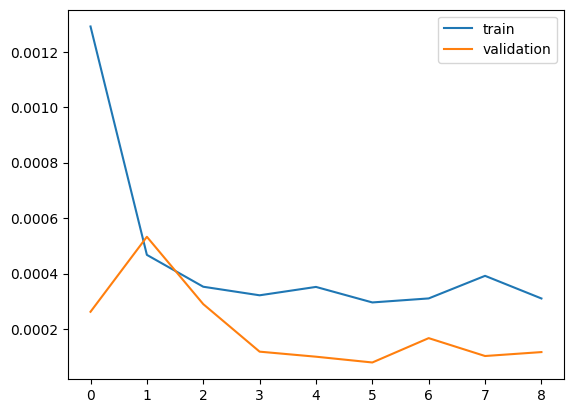

In [16]:
# Build the model with the optimal hyperparameters
model = build_model(best_hps.get('units'), best_hps.get('dropout_rate'), best_hps.get('learning_rate'))

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


In [17]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length])
    return np.array(sequences), np.array(labels)


In [18]:
sequence_lengths = [30, 60, 90, 180, 360]
results = {}

for seq_len in sequence_lengths:
    X, y = create_sequences(scaled_data, seq_len)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = build_model(best_hps.get('units'), best_hps.get('dropout_rate'), best_hps.get('learning_rate'))
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

    loss = model.evaluate(X_test, y_test)
    results[seq_len] = loss
    print(f'Sequence Length: {seq_len}, Test Loss: {loss}')

# Find the best sequence length
best_seq_len = min(results, key=results.get)
print(f'Best Sequence Length: {best_seq_len}')

Epoch 1/50
252/252 [==============================] - 10s 28ms/step - loss: 0.0021 - val_loss: 3.7850e-04
Epoch 2/50
252/252 [==============================] - 7s 27ms/step - loss: 4.6876e-04 - val_loss: 3.7537e-04
Epoch 3/50
252/252 [==============================] - 6s 23ms/step - loss: 4.1823e-04 - val_loss: 3.4958e-04
Epoch 4/50
252/252 [==============================] - 5s 22ms/step - loss: 3.9995e-04 - val_loss: 5.8958e-05
Epoch 5/50
252/252 [==============================] - 6s 22ms/step - loss: 2.8035e-04 - val_loss: 9.1244e-05
Epoch 6/50
252/252 [==============================] - 5s 22ms/step - loss: 4.0807e-04 - val_loss: 9.8634e-05
Epoch 7/50
79/79 [==============================] - 1s 8ms/step - loss: 4.9450e-04
Sequence Length: 30, Test Loss: 0.0004944963729940355
Epoch 1/50
251/251 [==============================] - 14s 44ms/step - loss: 0.0013 - val_loss: 3.5653e-04
Epoch 2/50
251/251 [==============================] - 11s 46ms/step - loss: 3.7205e-04 - val_loss: 1.0137e

In [19]:
!zip -r stock_price_tuning.zip stock_price_tuning/

  adding: stock_price_tuning/ (stored 0%)
  adding: stock_price_tuning/stock_price_prediction/ (stored 0%)
  adding: stock_price_tuning/stock_price_prediction/trial_3/ (stored 0%)
  adding: stock_price_tuning/stock_price_prediction/trial_3/trial.json (deflated 60%)
  adding: stock_price_tuning/stock_price_prediction/trial_3/checkpoint.data-00000-of-00001 (deflated 6%)
  adding: stock_price_tuning/stock_price_prediction/trial_3/checkpoint.index (deflated 62%)
  adding: stock_price_tuning/stock_price_prediction/trial_3/checkpoint (deflated 48%)
  adding: stock_price_tuning/stock_price_prediction/oracle.json (deflated 61%)
  adding: stock_price_tuning/stock_price_prediction/trial_0/ (stored 0%)
  adding: stock_price_tuning/stock_price_prediction/trial_0/trial.json (deflated 59%)
  adding: stock_price_tuning/stock_price_prediction/trial_0/checkpoint.data-00000-of-00001 (deflated 6%)
  adding: stock_price_tuning/stock_price_prediction/trial_0/checkpoint.index (deflated 61%)
  adding: stock_

In [20]:
!zip -r stock_price_tuning_grid.zip stock_price_tuning_grid/

  adding: stock_price_tuning_grid/ (stored 0%)
  adding: stock_price_tuning_grid/stock_price_prediction/ (stored 0%)
  adding: stock_price_tuning_grid/stock_price_prediction/trial_3/ (stored 0%)
  adding: stock_price_tuning_grid/stock_price_prediction/trial_3/trial.json (deflated 59%)
  adding: stock_price_tuning_grid/stock_price_prediction/trial_3/checkpoint.data-00000-of-00001 (deflated 6%)
  adding: stock_price_tuning_grid/stock_price_prediction/trial_3/checkpoint.index (deflated 61%)
  adding: stock_price_tuning_grid/stock_price_prediction/trial_3/checkpoint (deflated 48%)
  adding: stock_price_tuning_grid/stock_price_prediction/oracle.json (deflated 61%)
  adding: stock_price_tuning_grid/stock_price_prediction/trial_0/ (stored 0%)
  adding: stock_price_tuning_grid/stock_price_prediction/trial_0/trial.json (deflated 60%)
  adding: stock_price_tuning_grid/stock_price_prediction/trial_0/checkpoint.data-00000-of-00001 (deflated 6%)
  adding: stock_price_tuning_grid/stock_price_predict

In [21]:
!zip -r stock_price_tuning_hyperband.zip stock_price_tuning_hyperband/

  adding: stock_price_tuning_hyperband/ (stored 0%)
  adding: stock_price_tuning_hyperband/stock_price_prediction/ (stored 0%)
  adding: stock_price_tuning_hyperband/stock_price_prediction/trial_0048/ (stored 0%)
  adding: stock_price_tuning_hyperband/stock_price_prediction/trial_0048/trial.json (deflated 59%)
  adding: stock_price_tuning_hyperband/stock_price_prediction/trial_0048/checkpoint.data-00000-of-00001 (deflated 6%)
  adding: stock_price_tuning_hyperband/stock_price_prediction/trial_0048/checkpoint.index (deflated 61%)
  adding: stock_price_tuning_hyperband/stock_price_prediction/trial_0048/checkpoint (deflated 48%)
  adding: stock_price_tuning_hyperband/stock_price_prediction/trial_0011/ (stored 0%)
  adding: stock_price_tuning_hyperband/stock_price_prediction/trial_0011/trial.json (deflated 60%)
  adding: stock_price_tuning_hyperband/stock_price_prediction/trial_0011/checkpoint.data-00000-of-00001 (deflated 6%)
  adding: stock_price_tuning_hyperband/stock_price_prediction/t

In [22]:
!zip -r stock_price_tuning_bayesian.zip /content/drive/MyDrive/Colab/LSTM/stock_price_tuning_bayesian/

  adding: content/drive/MyDrive/Colab/LSTM/stock_price_tuning_bayesian/ (stored 0%)
  adding: content/drive/MyDrive/Colab/LSTM/stock_price_tuning_bayesian/stock_price_prediction/ (stored 0%)
  adding: content/drive/MyDrive/Colab/LSTM/stock_price_tuning_bayesian/stock_price_prediction/trial_06/ (stored 0%)
  adding: content/drive/MyDrive/Colab/LSTM/stock_price_tuning_bayesian/stock_price_prediction/trial_06/trial.json (deflated 59%)
  adding: content/drive/MyDrive/Colab/LSTM/stock_price_tuning_bayesian/stock_price_prediction/trial_06/checkpoint.data-00000-of-00001 (deflated 6%)
  adding: content/drive/MyDrive/Colab/LSTM/stock_price_tuning_bayesian/stock_price_prediction/trial_06/checkpoint.index (deflated 61%)
  adding: content/drive/MyDrive/Colab/LSTM/stock_price_tuning_bayesian/stock_price_prediction/trial_06/checkpoint (deflated 48%)
  adding: content/drive/MyDrive/Colab/LSTM/stock_price_tuning_bayesian/stock_price_prediction/oracle.json (deflated 63%)
  adding: content/drive/MyDrive